# De Rham Neural Networks

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import coo_matrix,diags
from scipy.sparse.linalg import inv
import gudhi as gd
import copy
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import torch

## Vector Fields

We first design some plotting functions to visualize vector fields. This will help us understand the features that our algorithm is learning. 

In [2]:
## initialise a random function from R^n to R^2
def random_linear_function(input, output_dim = 2):

    # get the dimension of the input
    input_dim = np.shape(input)[0]

    # initialise a random matrix of dim input_dim x output_dim
    A = np.random.uniform(-1,1,(input_dim,output_dim))
    
    return input @ A


## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, x_range, y_range, ax):

    x = np.linspace(x_range[0],x_range[1],20)
    y = np.linspace(y_range[0],y_range[1],20)
    X,Y = np.meshgrid(x,y)


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            U[i,j] = f([X[i,j],Y[i,j]])[0]
            V[i,j] = f([X[i,j],Y[i,j]])[1]
    ax.quiver(X,Y,U,V)

    

## plot the vector field of a random function
def plot_random_vector_field():
    f = random_function()
    fig, ax = plt.subplots()
    plot_vector_field(f, [-1,1], [-1,1], ax)
    plt.show()

As a first example, we will consider vector fields over $\mathbb{R}^2$. $1$-forms, which are in bijection with and dual to vector fields, can be written in the form:
$\begin{equation} \omega = f_x(x,y) dx + f_y(x,y) dy \end{equation}$ where both $f_x$ and $f_y$ are functions from $\mathbb{R}^2$ to $\mathbb{R}$. By the identification
$ \begin{equation} \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \oplus  \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \cong \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}^2)  \end{equation}$ we can represent a $1$-form as a single function from $\mathbb{R}^2 \to \mathbb{R}^2$. To learn such a function, we define a simple MLP below which goes from $\mathbb{R}^2 \to \mathbb{R}^2$.

In [3]:
import torch
import torch.nn as nn
 
# initialise a vector field as a MLP
vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

To drive home the fact that the above MLP actually defines a vector field, we can plot it. The 'tangent vector' at each point $(x,y) \in \mathbb{R}^2$ is the vector given by
$\begin{equation}  (f_x(x,y),f_y(x,y)) \end{equation}$ which corresponds to the MLP above via
$\begin{equation} f_x(x,y) = \pi_x \circ \text{vf.forward}(x,y) \end{equation}$ and $\begin{equation} f_y(x,y) = \pi_y \circ \text{vf.forward}(x,y). \end{equation}$

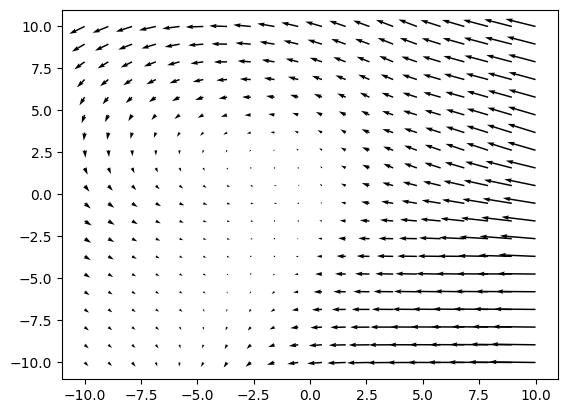

In [4]:
## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, ax, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            U[i,j] = f.forward(inp)[0]
            V[i,j] = f.forward(inp)[1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

plot_vector_field(vf, ax, x_range=10, y_range=10)

plt.show()


In [5]:
## plot a vector field given a function f: R^2 -> R^2
def plot_feature_vf(f, ax, i = 0, x_range=np.array([-5,5]), y_range=np.array([-5,5])):

    x = np.linspace(-5,5,20)
    y = np.linspace(-5,5,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            U[i,j] = f.forward(inp)[0]
            V[i,j] = f.forward(inp)[1]
    ax.quiver(X,Y,U,V)


Now we make a neural network that learns multiple vector fields.

In [14]:
c = 6 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 2 * c)
)

vf

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=2, bias=True)
)

#### Calculating line integrals of vector fields along linear paths

In [7]:
# parametrize a line between two points
def line(x,y,n = 50):
    
    t = np.linspace(0,1,n)

    # make t into a column vector
    t = np.reshape(t, (n,1))

    return torch.tensor((1-t) @ x + t @ y).float()



In [18]:
l = line(np.array([[0,1]]),np.array([[1,0]]))

In [19]:
def trapz(y, l):
    """Approximate the definite integral of y=f(x) using the trapezoidal rule.

    Parameters
    ----------
    y : array_like
        Array of y values of f(x).
    l : array_like
        Array of linear values along a line
    
    Returns
    -------
    trapz : float
        Definite integral as approximated by trapezoidal rule.

    """

    # difference between each point on the line
    d = torch.norm(torch.diff(l.T).T,dim=1)

    # pointwise multiplication of y[0:-1] + y[1:] and d
    return torch.sum((y[0:-1] + y[1:]) * d / 2)

In [20]:
def vf_eval(vf,line):
    # evaluate the vector field vf along the line
    # vf is a torch.nn.Sequential object
    # line is a torch.tensor object
    # returns a torch.tensor object
    n = line.shape[0]
    out = torch.zeros((n,2))

    # replace the following with a vectorised version
    for i in range(n):
        out[i,:] = vf(line[i,:])

    # gradient of the line
    l_grad = (line[-1] - line[0])/np.linalg.norm(line[-1] - line[0])

    # turn l_grad into a column vector that automatically determines the number of rows
    l_grad = torch.reshape(l_grad, (l_grad.shape[0],1))




    return out @ l_grad
    

    

In [21]:
trapz(vf_eval(vf,l),l)

tensor(11.8119, grad_fn=<SumBackward0>)

In [22]:
def integrate(vf,l):
    eval = vf_eval(vf,l)
    return trapz(eval,l)

In [23]:
integrate(vf,l)

tensor(11.8119, grad_fn=<SumBackward0>)

### Synthetic Dataset of paths

In [25]:
## plot a set of points and connect consecutive points with lines
def plot_points(points, ax, color = 'black', alpha = 1, linewidth = 1):

    n = points.shape[0]

    for i in range(n-1):
        ax.plot(points[i:i+2,0],points[i:i+2,1], color = color, alpha = alpha, linewidth = linewidth)

    return ax


tensor([[0.0000, 1.0000],
        [0.0204, 0.9796],
        [0.0408, 0.9592],
        [0.0612, 0.9388],
        [0.0816, 0.9184],
        [0.1020, 0.8980],
        [0.1224, 0.8776],
        [0.1429, 0.8571],
        [0.1633, 0.8367],
        [0.1837, 0.8163],
        [0.2041, 0.7959],
        [0.2245, 0.7755],
        [0.2449, 0.7551],
        [0.2653, 0.7347],
        [0.2857, 0.7143],
        [0.3061, 0.6939],
        [0.3265, 0.6735],
        [0.3469, 0.6531],
        [0.3673, 0.6327],
        [0.3878, 0.6122],
        [0.4082, 0.5918],
        [0.4286, 0.5714],
        [0.4490, 0.5510],
        [0.4694, 0.5306],
        [0.4898, 0.5102],
        [0.5102, 0.4898],
        [0.5306, 0.4694],
        [0.5510, 0.4490],
        [0.5714, 0.4286],
        [0.5918, 0.4082],
        [0.6122, 0.3878],
        [0.6327, 0.3673],
        [0.6531, 0.3469],
        [0.6735, 0.3265],
        [0.6939, 0.3061],
        [0.7143, 0.2857],
        [0.7347, 0.2653],
        [0.7551, 0.2449],
        [0.7

<Axes: >

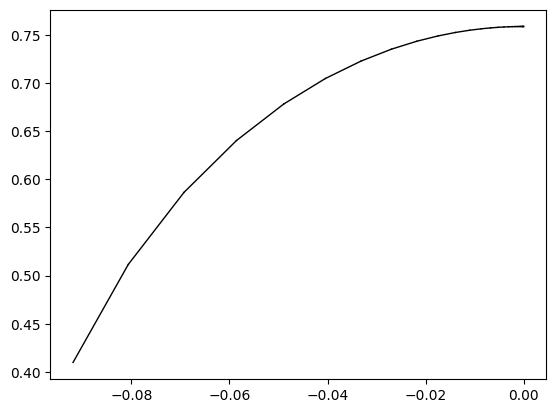

In [72]:
# make a random point cloud in R2

n = 100

points = np.random.uniform(-1,1,(n,2))



# make a random polynomial combination of sin and cos functions

def random_polynomial(n = 1):
    
        # initialise a random vector of length n
        coeffs = np.random.uniform(-1,1,n)
    
        # initialise a random vector of length n
        exponents = np.random.randint(0,10,n)
    
        # initialise a random vector of length n
        functions = np.random.choice([np.sin,np.cos],n)
    
        # initialise a random vector of length n
        signs = np.random.choice([-1,1],n)
    
        def f(x):
            out = 0
            for i in range(n):
                out += signs[i] * coeffs[i] * functions[i](x**exponents[i])
            return out
    
        return f


f = random_polynomial()
g = random_polynomial()

points = np.array([f(np.linspace(0,1)),g(np.linspace(0,1))]).T

fig, ax = plt.subplots()
points

plot_points(points, ax)




<Axes: >

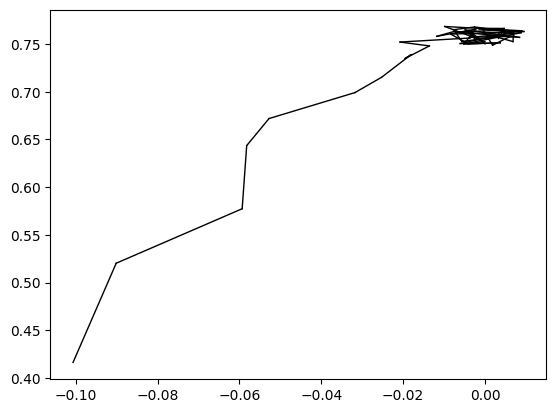

In [73]:
## add random noise to points
def add_noise(points, noise = 0.01):
    return points + np.random.uniform(-noise,noise,points.shape)

noise_points = add_noise(points)

fig, ax = plt.subplots()
plot_points(noise_points, ax)


In [57]:
np.linspace(0,1)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])